In [24]:
import networkx as nx
import pandas as pd
import numpy as np
import datetime
import random
import pickle
import os
import time
import statistics as st
from decimal import Decimal as D
from decimal import ROUND_DOWN

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

from lib.Line import Line
from lib.Station import Station
from lib.Platform import Platform
from lib.Passenger import Passenger
from lib.Train import Train
from lib.RailwayNetwork import RailwayNetwork

## Load raw data of passengers

Raw data with the number of in-out passengers per station and time window.

In [119]:
DATA_PATH = '../Data/madrid/'
PARSED_PATH = DATA_PATH + 'parsed/'
IMAGES_PATH = DATA_PATH + 'images/'

FLOW_IMAGES_PATH = IMAGES_PATH + 'flow/'
CUM_INFECTION_IMAGES_PATH = IMAGES_PATH + 'infection/cum/'
STEP_INFECTION_IMAGES_PATH = IMAGES_PATH + 'infection/step/'

os.makedirs(FLOW_IMAGES_PATH, exist_ok=True)
os.makedirs(CUM_INFECTION_IMAGES_PATH, exist_ok=True)
os.makedirs(STEP_INFECTION_IMAGES_PATH, exist_ok=True)

In [3]:
connections = pd.read_csv(PARSED_PATH + 'station_connections.csv', index_col=False)
timetable = pd.read_csv(PARSED_PATH + 'timetable.csv', index_col=False)
w_lines = pd.read_csv(PARSED_PATH + 'line_weights.csv', index_col=False)
w_times = pd.read_csv(PARSED_PATH + 'times_weights.csv', index_col=False)
w_stations = pd.read_csv(PARSED_PATH + 'station_weights.csv', index_col=False)
station_coords = pd.read_csv(PARSED_PATH + 'station_coords.csv', index_col=False)

In [4]:
# Transform strings to time objects
timetable['ARRIVAL_TIME'] = pd.to_datetime(timetable['ARRIVAL_TIME'])
timetable['ARRIVAL_TIME'] = [t.time() for t in timetable['ARRIVAL_TIME']]

timetable['DEPARTURE_TIME'] = pd.to_datetime(timetable['DEPARTURE_TIME'])
timetable['DEPARTURE_TIME'] = [t.time() for t in timetable['DEPARTURE_TIME']]

w_times['TIME'] = pd.to_datetime(w_times['TIME'])
w_times['TIME'] = [t.time() for t in w_times['TIME']]
w_times['WEIGHT_IN'] = [D(w) for w in w_times['WEIGHT_IN']]

w_lines['WEIGHT_IN'] = [D(w) for w in w_lines['WEIGHT_IN']]
w_lines['WEIGHT_OUT'] = [D(w) for w in w_lines['WEIGHT_OUT']]

w_stations['TIME'] = pd.to_datetime(w_stations['TIME'])
w_stations['TIME'] = [t.time() for t in w_stations['TIME']]
w_stations['WEIGHT_IN'] = [D(w) for w in w_stations['WEIGHT_IN']]
w_stations['WEIGHT_OUT'] = [D(w) for w in w_stations['WEIGHT_OUT']]

In [5]:
# Cast values
connections = connections.astype({'DIRECTION': 'int32'})
timetable = timetable.astype({'IS_START': 'int32', 'IS_END': 'int32', 'DIRECTION': 'int32'})
station_coords = station_coords.astype({'X': 'float', 'Y': 'float'})

In [6]:
# Set indexes
connections = connections.set_index(['LINE', 'FROM_STATION'])
timetable = timetable.set_index(['LINE', 'STATION_NAME'])
w_lines = w_lines.set_index(['LINE'])
w_times = w_times.set_index(['TIME'])
w_stations = w_stations.set_index(['LINE', 'STATION_NAME', 'TIME'])
station_coords = station_coords.set_index(['STATION_NAME'])

In [7]:
w_stations.head()

WEIGHT_IN  \
LINE STATION_NAME TIME                 
C10  PRINCIPE PIO 00:00:00         0   
                  00:01:00         0   
                  00:02:00         0   
                  00:03:00         0   
                  00:04:00         0   

                                                                   WEIGHT_OUT  
LINE STATION_NAME TIME                                                         
C10  PRINCIPE PIO 00:00:00  0.52994446446603182820922484097536653280258178...  
                  00:01:00  0.52994446446603182820922484097536653280258178...  
                  00:02:00  0.52994446446603182820922484097536653280258178...  
                  00:03:00  0.52994446446603182820922484097536653280258178...  
                  00:04:00  0.52994446446603182820922484097536653280258178...

## Build dictionaries

In [8]:
station_names = connections.reset_index()['FROM_STATION'].unique()

In [9]:
# Build dictionary: name of stations -> numerical ID
station2id = {st_name:i for i, st_name in enumerate(station_names)}
id2station = {i:st_name for i, st_name in enumerate(station_names)}

In [10]:
# Example of getting a value of a line-station in a specific time
k_time = datetime.time(15, 0) # 15PM
w_stations.loc[('C5', 'ATOCHA', k_time), 'WEIGHT_IN']

Decimal('41.659471990957598563909414224326610565185546875')

## Run one-day flow simulation

First we need to initialize the objects of the network:

In [11]:
# Time of service (set to None if it never closes)
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM

n_passengers = 400000

network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations, timetable, connections)
stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}

# Once every object is created, add to them to the network and init it
network.init_network(lines, stations, debug=True)

Network is ready!                                                                   


In [12]:
# Uncomment if we want to save/load a network state

"""with open(PARSED_PATH + 'network.pickle', 'wb') as fp:
    pickle.dump(network, fp, pickle.HIGHEST_PROTOCOL)"""

"""with open(PARSED_PATH + 'network.pickle', 'rb') as fp:
    network = pickle.load(fp)"""

"with open(PARSED_PATH + 'network.pickle', 'rb') as fp:\n    network = pickle.load(fp)"

In [13]:
# Sample station
s = Station(network, 'FUENLABRADA', w_stations)
print(s.get_weight(line_name='C5'))

(Decimal('18111.99999999999739053180306'), Decimal('16222.99999999999725708299526'))


In [14]:
G = nx.Graph()

G.add_nodes_from(station2id.values())

# Add attributes to nodes
for st_name, node_id in station2id.items():
    pos_x = station_coords.at[st_name, 'X']
    pos_y = station_coords.at[st_name, 'Y']
    G.add_node(node_id, pos=(pos_x, pos_y), station=stations[st_name])

# Add edges
for i, row in connections.iterrows():
    node_from = station2id[i[1]]
    node_to = station2id[row['TO_STATION']]
    
    G.add_edge(node_from, node_to)

In [197]:
def get_cmap(max_scale):
    # Color mapping for nodes
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0) # Force the first color entry to be grey

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_over('#811a17')

    # define the bins and normalize
    bounds = np.linspace(0, max_scale)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [15]:
max_scale = 150 # Max value in the scale of colors
cmap = get_cmap(max_scale) # Color mapping for nodes

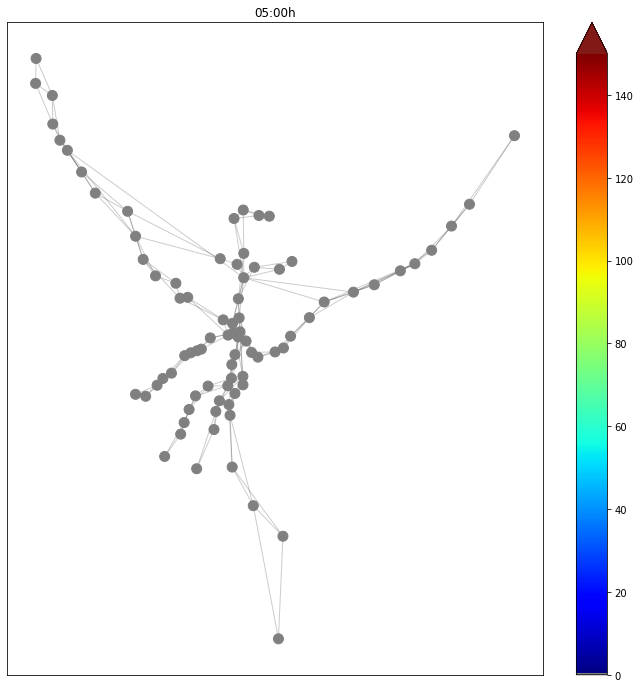

In [16]:
# This section code is just for debug purposes (to see visually the shape of the network)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

pos = nx.get_node_attributes(G, 'pos')

colors = [s.get_n_passengers() for node_id, s in nx.get_node_attributes(G, 'station').items()]

ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
fig.colorbar(nc, extend='max')

Then we can proceed to run the simulation:

In [17]:
# Display how the number of passengers change on each station

n_iters = 20 * 60 # 20 hours * 60 minutes

pos = nx.get_node_attributes(G, 'pos')

network.reset()

for i in range(n_iters):
    print('\r%d of %d' % (i + 1, n_iters), ' '*10, end='')
    
    network.step()
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

    colors = [s.get_n_passengers() for node_id, s in nx.get_node_attributes(G, 'station').items()]

    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                                with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
    fig.colorbar(nc, extend='max', ax=ax)
    
    fig.savefig('%s%s.png' % (FLOW_IMAGES_PATH, network.get_time().strftime('%H-%M')))
    plt.close(fig)
    
print('')
print('Simulation finished!', ' '*10)

1200 of 1200           Finish!           


## Experiment infections

Based on the results published by Los Alamos National Laboratory (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), the value $R_0$ should be around $5.7$, so we run a few tests to find a value for $p$.

Using a simple SEI model (i.e. without *recovered* state), each infected passenger is able to infect other passengers (who are in the same place as the infected one) with a probability $p$.

Once the day has finished, we compute the global $R_0$ as the mean of the number of infections.

In [109]:
# Initial variables
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM
n_passengers = 500000
n_initial_infected = 50000 # 10% of infected passengers
n_iters = 20 * 60 # 20 hours * 60 minutes

pos = nx.get_node_attributes(G, 'pos')

p_set = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
r0_set = []
total_repeat = 1

for p in p_set:
    print('-' * 10)
    print('P value: %.4f' % p)

    try:
        if network is not None:
            del network
    except:
        # Var not defined
        pass
    
    # Build network objects
    network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations,
                             timetable, connections, n_initial_infected, p, auto_reset=False)
    stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
    lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}
    network.init_network(lines, stations)

    r0_loop = []
    
    for i_repeat in range(total_repeat):
        network.reset()
        for i in range(n_iters):
            print('\rStep %d of %d (repetition %d of %d)' % (i + 1, n_iters, i_repeat + 1, total_repeat), ' '*10, end='')
            network.step()
        
        # Compute R0 value
        infected_passengers = [passenger for passenger in network.get_passengers() if passenger.get_infected_status() == 2]
        for passenger in infected_passengers:
            r0_loop.append(passenger.get_n_infections())
    
    print('')
    
    # R0 is the average of infected people per time step (i.e. per day)
    r0_set.append(st.mean(r0_loop) if len(r0_loop) > 0 else 0)
    print('R0 value: %.4f' % r0_set[-1])
    
    # Free memory
    del network

print('')
print('Simulation finished!', ' '*10)

----------
P value: 0.0010
Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 2.1017
----------
P value: 0.0025
Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 3.6502
----------
P value: 0.0050


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 5.0477
----------
P value: 0.0100


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 6.3037
----------
P value: 0.0250


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 7.5430
----------
P value: 0.0500


Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Step 1200 of 1200 (repetition 1 of 1)           
R0 value: 8.1716

Simulation finished!           


In [110]:
print(p_set)
print(r0_set)

[0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
[2.10168, 3.65016, 5.0477, 6.3037, 7.54298, 8.17162]


# Run one-day infection simulation

Once we have an idea of the $p$ value to use, we proceed to run a one-day infection simulation. Note that the code is almost the same as in the *flow simulation*.

In [112]:
# Time of service (set to None if it never closes)
open_time = datetime.time(5, 0) # 5AM
close_time = datetime.time(1, 0) # 1AM
n_passengers = 500000
n_initial_infected = 50000 # 10% of infected passengers
n_iters = 20 * 60 # 20 hours * 60 minutes
p_infection = 0.005 # Probability of getting infected if a passenger is in contact with an infected one
max_scale = 10000 # In the scale of colors, this is the max value

# Build network objects
network = RailwayNetwork(n_passengers, open_time, close_time, w_times, w_lines, w_stations,
                         timetable, connections, n_initial_infected, p_infection, auto_reset=False)
stations = {st_name:Station(network, st_name, w_stations) for st_name in station_names}
lines = {line_name:Line(network, line_name, w_lines) for line_name in w_lines.index}

network.init_network(lines, stations, debug=True)

Exception ignored in: <function RailwayNetwork.__del__ at 0x000001C4FB67AAF8>
Traceback (most recent call last):
  File "D:\Documentos\Master\Network Science\NS_Epidemics_ABM_Approach\Repository\NoteBooksAbm\lib\RailwayNetwork.py", line 286, in __del__
    del self.stations[:]
TypeError: unhashable type: 'slice'


Network is ready!                                                                                                                                                                                                                                                                                                                              


In [113]:
# Build network graph
G = nx.Graph()
G.add_nodes_from(station2id.values())

# Add attributes to nodes
for st_name, node_id in station2id.items():
    pos_x = station_coords.at[st_name, 'X']
    pos_y = station_coords.at[st_name, 'Y']
    G.add_node(node_id, pos=(pos_x, pos_y), station=stations[st_name])

# Add edges
for i, row in connections.iterrows():
    node_from = station2id[i[1]]
    node_to = station2id[row['TO_STATION']]
    
    G.add_edge(node_from, node_to)

# Color mapping for nodes
cmap = get_cmap(max_scale)

In [114]:
# Display how the number of infected passengers change on each station
# Note that this the ACCUMULATED number of infections

pos = nx.get_node_attributes(G, 'pos')
network.reset()

for i in range(n_iters):
    print('\r%d of %d' % (i + 1, n_iters), ' '*10, end='')
    
    network.step()
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('%sh' % network.get_time().strftime('%H:%M'))

    colors = [s.get_n_infections() for node_id, s in nx.get_node_attributes(G, 'station').items()]

    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors, 
                                with_labels=False, node_size=100, cmap=cmap, norm=norm, vmax=max_scale)
    fig.colorbar(nc, extend='max', ax=ax)
    
    fig.savefig('%s%s.png' % (CUM_INFECTION_IMAGES_PATH, network.get_time().strftime('%H-%M')))
    plt.close(fig)

print('')
print('Simulation finished!', ' '*10)

1200 of 1200           
Simulation finished!           


### Evaluation of infection simulation

In [115]:
# Average R0
r0 = []
infected_passengers = [passenger for passenger in network.get_passengers() if passenger.get_infected_status() == 2]
for passenger in infected_passengers:
    r0.append(passenger.get_n_infections())

r0 = st.mean(r0) if len(r0) > 0 else 0
print('R0 value: %.4f' % r0)

R0 value: 5.0502


In [116]:
# Ranking of most dangerous stations
top = 20
ranking_stations = sorted(stations.values(), key=lambda s: s.get_n_infections(), reverse=True)

for i, s in enumerate(ranking_stations[0:top]):
    print('%d - %s -> %d' % (i + 1, s.get_name(), s.get_n_infections()))

1 - ATOCHA -> 48063
2 - NUEVOS MINISTERIOS -> 15391
3 - CHAMARTIN -> 9064
4 - SOL -> 8699
5 - PRINCIPE PIO -> 5148
6 - MENDEZ ALVARO -> 4154
7 - PARLA -> 3777
8 - RECOLETOS -> 3334
9 - ARAVACA -> 2531
10 - VILLAVERDE ALTO -> 2398
11 - PIRAMIDES -> 2319
12 - VILLALBA -> 2107
13 - RAMON Y CAJAL -> 1918
14 - CANTOBLANCO UNIVERSIDAD -> 1782
15 - VILLAVERDE BAJO -> 1447
16 - GETAFE CENTRO -> 1381
17 - POZUELO -> 1297
18 - FUENTE DE LA MORA -> 1263
19 - DELICIAS -> 1188
20 - ROZAS LAS -> 1088


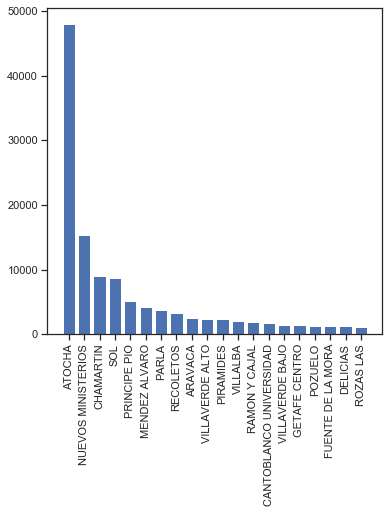

In [117]:
ranking_station_names = [s.get_name() for s in ranking_stations[0:top]]
ranking_station_values = [s.get_n_infections() for s in ranking_stations[0:top]]

fig = plt.figure(figsize=(6, 6))
plt.bar(ranking_station_names, ranking_station_values)
plt.xticks(ranking_station_names, rotation='vertical')
plt.show()
plt.close(fig)

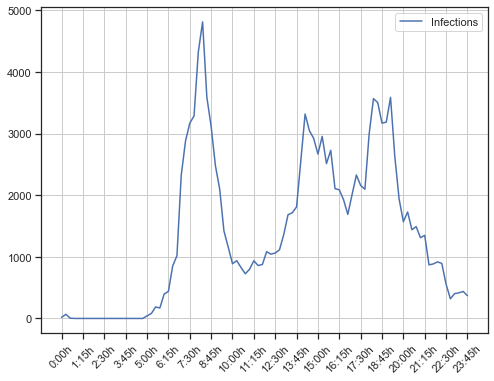

In [211]:
# Number of infections in a timeline

time_window = '15Min'

time_infections = []
for name, s in stations.items():
    time_infections = time_infections + s.get_time_infections()

# Use Pandas as it is easier to group by time interval
df = pd.DataFrame(time_infections, columns=['Time'])
df['Value'] = 1
df = df.append(pd.Series({'Time': '00:00:00', 'Value': 0}), ignore_index=True) # Add to force to start at 0:00h
df = df.groupby('Time').sum()
df.index = pd.to_timedelta(df.index.astype(str))
df = df.resample(time_window, base=0).sum()

# Function to format TimeDelta objects
def strfdelta(tdelta, fmt):
    d = {'days': tdelta.days}
    d['hours'], rem = divmod(tdelta.seconds, 3600)
    d['minutes'], d['seconds'] = divmod(rem, 60)
    d['minutes'] = d['minutes'] if d['minutes'] >= 10 else '0%d' % d['minutes']
    return fmt.format(**d)

x_labels = [strfdelta(t, '{hours}:{minutes}h') for t in df.index]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x_labels, df['Value'], label='Infections')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()
plt.close(fig)

We can analyze the same data per station as above:

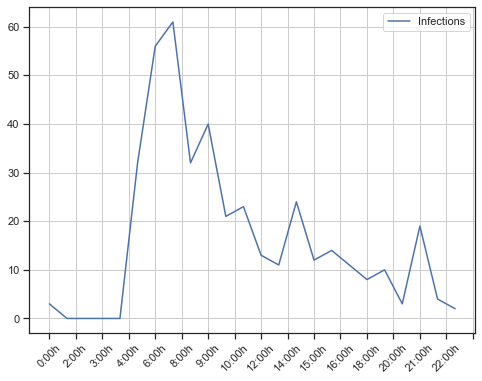

In [212]:
# Number of infections in a timeline

time_window = '1H'

station_name = 'FUENLABRADA'
time_infections = network.get_stations()[station_name].get_time_infections()

# Use Pandas as it is easier to group by time interval
df = pd.DataFrame(time_infections, columns=['Time'])
df['Value'] = 1
df = df.append(pd.Series({'Time': '00:00:00', 'Value': 0}), ignore_index=True) # Add to force to start at 0:00h
df = df.groupby('Time').sum()
df.index = pd.to_timedelta(df.index.astype(str))
df = df.resample(time_window, base=0).sum()

x_labels = [strfdelta(t, '{hours}:{minutes}h') for t in df.index]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x_labels, df['Value'], label='Infections')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()
plt.close(fig)